In [ ]:
# https://zhuanlan.zhihu.com/p/692810462 RF
# https://zhuanlan.zhihu.com/p/692505141 SVM

# https://zhuanlan.zhihu.com/p/112009086 Xboost

In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
expr = readRDS('./expr.rds')

In [3]:
rownames(expr)  = expr[,1]

In [4]:
expr1 = expr[,-c(1,2)]

In [5]:
table(expr$Group)


    MDD control 
    118      43 

In [6]:
head(expr,3)

,Symbol,Group,ABCB1,DBP,ADCY1,MAPK9,ID3,CASP1,FAS,UBE3A,...,CSF2,PRKDC,IL6,EGFR,MAPK10,PPARGC1A,NMU,NFIL3,SIAH2,PPP1CB
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1124358,GSM1124358,control,2.006582,2.088067,2.209855,2.125476,2.105605,1.826383,1.871490,2.016419,...,1.89301,1.980718,2.294302,2.070409,2.344453,1.932350,1.722470,2.361215,2.118150,2.122166
GSM1124359,GSM1124359,MDD,2.014495,2.141035,2.248393,2.256796,2.113936,1.775478,1.777546,2.046408,...,1.87103,2.013405,1.772629,2.029070,2.383743,1.996535,1.995799,1.941229,2.071485,2.150242
GSM1124360,GSM1124360,MDD,1.974940,2.113552,2.218243,2.270442,2.108627,1.768256,1.801689,2.051127,...,1.86114,2.032160,1.761333,2.012310,2.403887,2.013150,1.975217,1.982229,2.079847,2.190608


In [7]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
expr %>% filter(Group == 'control') %>% rownames(.) -> control
expr %>% filter(Group == 'MDD') %>% rownames(.) -> MDD

In [9]:
expr2 = expr1[c(control,MDD),]

In [10]:
head(expr2,2)

,ABCB1,DBP,ADCY1,MAPK9,ID3,CASP1,FAS,UBE3A,IGF1,CNTNAP2,...,CSF2,PRKDC,IL6,EGFR,MAPK10,PPARGC1A,NMU,NFIL3,SIAH2,PPP1CB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1124358,2.006582,2.088067,2.209855,2.125476,2.105605,1.826383,1.871490,2.016419,1.915631,1.991902,...,1.89301,1.980718,2.294302,2.070409,2.344453,1.932350,1.72247,2.361215,2.118150,2.122166
GSM1124365,2.020538,2.088836,2.246839,2.235349,2.090293,1.756460,1.768088,2.070301,1.920998,2.015574,...,1.85964,2.034991,1.759261,2.031724,2.388001,2.047965,1.85660,1.958817,2.029774,2.182368


In [11]:
Type = c(rep(1,length(control)),rep(2,length(MDD)))

In [12]:
x = as.matrix(expr2)

y = Type


In [13]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 4.2.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine




In [14]:
set.seed(1234)

In [15]:
rf = randomForest(as.factor(y)~.,data = x,ntree =1000,important=TRUE,proximity=TRUE)

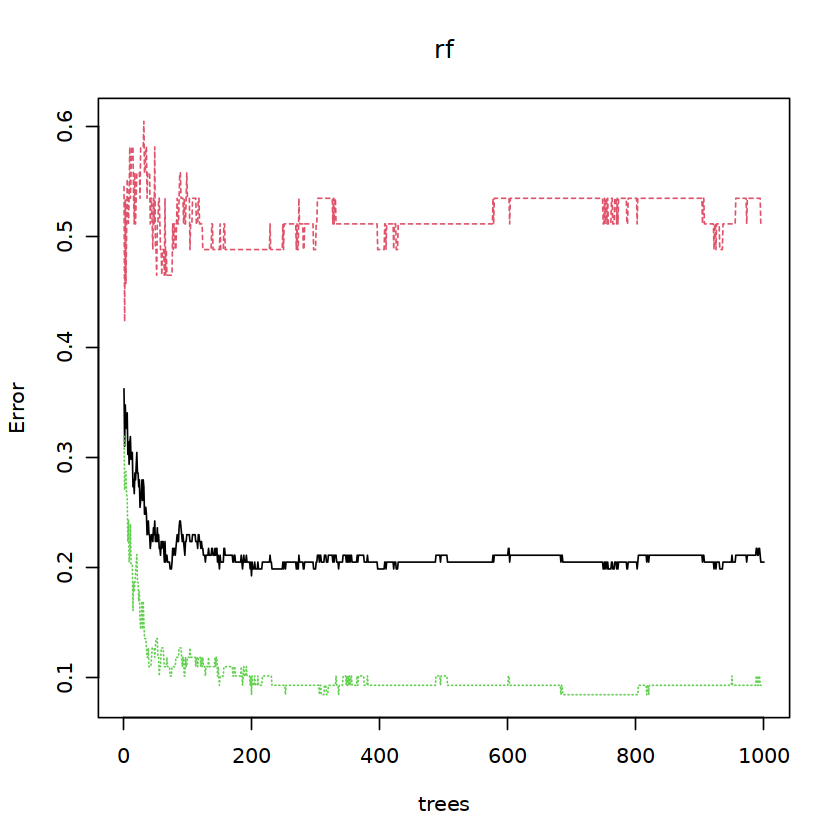

In [16]:
plot(rf)

In [17]:
pdf('forest.pdf',height = 6,width = 6)
plot(rf)
dev.off()

png 
  2

In [18]:
trees = which.min(rf$err.rate[,1])

In [19]:
rf = randomForest(as.factor(y)~.,data = x,ntree =trees,important=TRUE,proximity=TRUE)

In [20]:
importance = importance(rf)

In [21]:
pdf('forest2.pdf',height = 6,width = 6)
varImpPlot(rf,main = '')
dev.off()

png 
  2

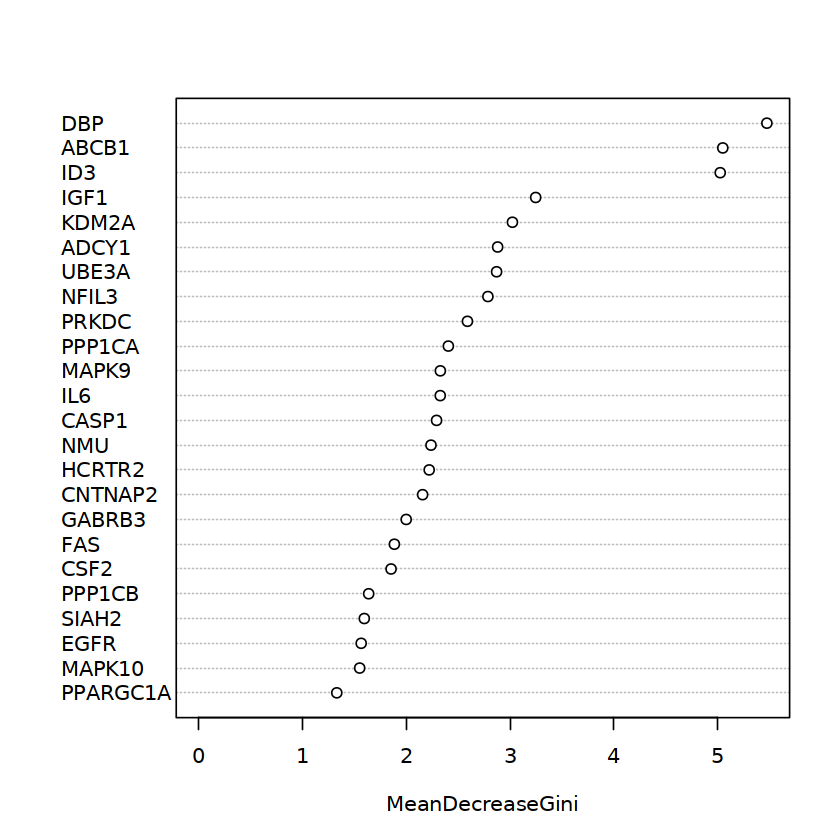

In [22]:
varImpPlot(rf,main = '')

In [23]:
rfGenes=importance[order(importance[, "MeanDecreaseGini"], decreasing  = TRUE),] #重要性评分大于2的基因

In [24]:
rfGenes

DBP    ABCB1      ID3     IGF1    KDM2A    ADCY1    UBE3A    NFIL3 
5.475496 5.050358 5.025649 3.246386 3.022215 2.879733 2.869699 2.785758 
   PRKDC   PPP1CA    MAPK9      IL6    CASP1      NMU   HCRTR2  CNTNAP2 
2.588514 2.404454 2.327402 2.326445 2.290970 2.237156 2.219752 2.156235 
  GABRB3      FAS     CSF2   PPP1CB    SIAH2     EGFR   MAPK10 PPARGC1A 
1.998077 1.884109 1.852221 1.636383 1.594115 1.564095 1.549574 1.328870

In [25]:
rfGenes=names(rfGenes[rfGenes>30]) 
write.table(rfGenes,file="rfGenes.txt",sep="\t",quote=F,col.names=F,row.names=F) #输出表达量

In [26]:
sigExp=expr2[rfGenes,]
write.table(data.frame(ID=rownames(sigExp),sigExp),file="rfGeneExp.txt",sep="\t",quote=F,col.names=T,row.names=F) 

### svm

In [593]:
library(tidyverse)
library(glmnet)
library(VennDiagram)
library(e1071)
library(caret)
library(randomForest)

In [594]:
y=as.numeric(as.factor(Type))

In [595]:
library(future)
plan("multisession",workers=30)

In [596]:
set.seed(1)
rfeControl = rfeControl(functions = caretFuncs,
                        method = "cv", # 默认自助法重采样 boot
                        saveDetails = T, # 保存预测值和变量重要性
                        number = 5, # 重抽样次数
                        allowParallel = T # 允许多线程，用这个之前你要先准备好多线程！
                        )

In [598]:
Profile=rfe(x=x,y=y,sizes = c(1:10),
    rfeControl =  rfeControl,
    methods="svmRadial")

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



In [599]:
Profile


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE  RMSESD RsquaredSD   MAESD Selected
         1 0.5081  0.06882 0.3620 0.05420    0.06472 0.06499         
         2 0.4498  0.14178 0.3200 0.03727    0.09045 0.02864         
         3 0.4176  0.18942 0.3020 0.03226    0.07960 0.01310         
         4 0.4075  0.21335 0.2985 0.03102    0.06608 0.02270         
         5 0.3924  0.28297 0.2911 0.04683    0.11033 0.03800         
         6 0.3900  0.27438 0.2913 0.03761    0.10928 0.03282         
         7 0.3841  0.28999 0.2898 0.03185    0.13146 0.02783        *
         8 0.3844  0.28879 0.2942 0.03375    0.13707 0.03032         
         9 0.3902  0.25827 0.2983 0.02928    0.09944 0.02544         
        10 0.3898  0.26868 0.3010 0.03203    0.11791 0.02905         
        24 0.3894  0.26131 0.3126 0.02436    0.12486 0.02533         

The top 5 variables (out of 7):
   

In [600]:
pdf(file="SVM-RFE.pdf", width=6, height=5.5)
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)
dev.off()

png 
  2

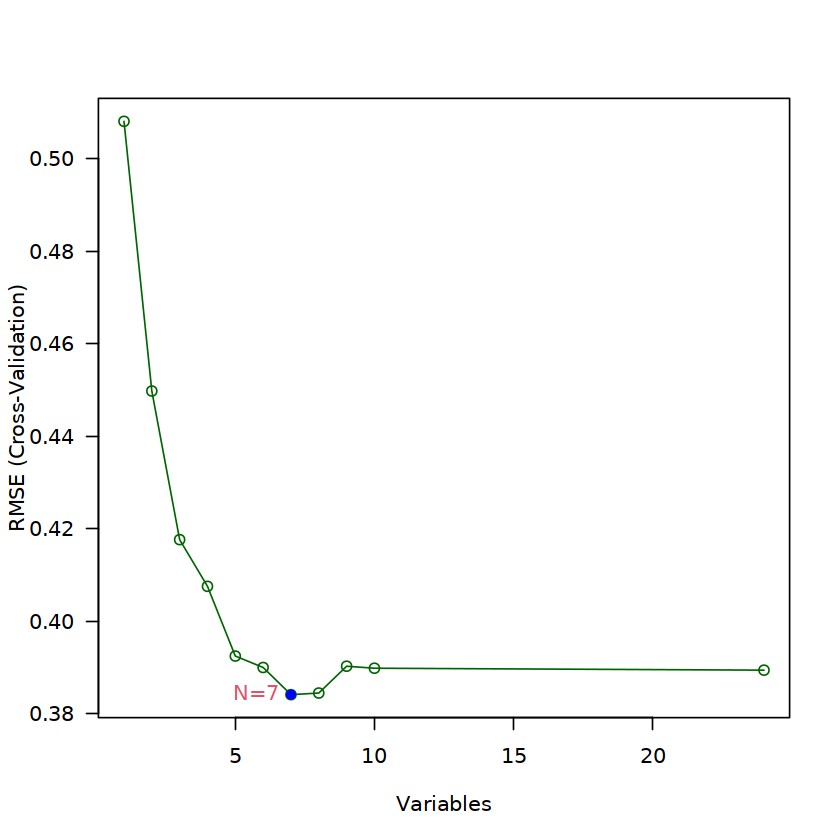

In [601]:
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)

In [602]:
#输出
featureGenes = Profile$optVariables
write.table(file="SVM-RFE.gene.txt",featureGenes,sep="\t",quote=F,row.names=F,col.names=F) #表达矩阵 

### Boruta

In [27]:
library(Boruta)

In [28]:
x = as.matrix(expr2)
y = Type

In [29]:
y

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2

In [30]:
set.seed(1)
boruta <- Boruta(x=x, y=y, pValue=0.05, mcAdj=T, 
       maxRuns=300)

In [31]:
table(boruta$finalDecision)


Tentative Confirmed  Rejected 
        2        11        11 

In [32]:
boruta$finalDecision

ABCB1       DBP     ADCY1     MAPK9       ID3     CASP1       FAS     UBE3A 
Confirmed Confirmed Confirmed  Rejected Confirmed Confirmed  Rejected Confirmed 
     IGF1   CNTNAP2    PPP1CA    GABRB3    HCRTR2     KDM2A      CSF2     PRKDC 
Confirmed Tentative Confirmed  Rejected  Rejected Confirmed  Rejected Confirmed 
      IL6      EGFR    MAPK10  PPARGC1A       NMU     NFIL3     SIAH2    PPP1CB 
 Rejected  Rejected  Rejected Tentative  Rejected Confirmed  Rejected  Rejected 
Levels: Tentative Confirmed Rejected

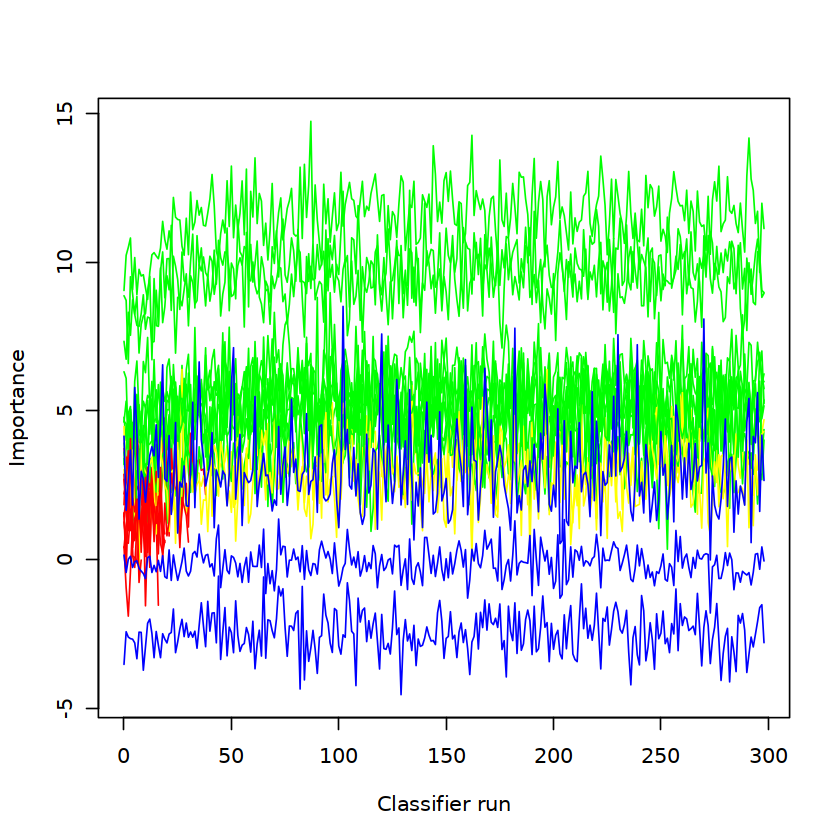

In [33]:
Boruta::plotImpHistory(boruta)

In [34]:
library(dplyr)
boruta.imp <- function(x){
  imp <- reshape2::melt(x$ImpHistory, na.rm=T)[,-1]
  colnames(imp) <- c("Variable","Importance")
  imp <- imp[is.finite(imp$Importance),]

  variableGrp <- data.frame(Variable=names(x$finalDecision), 
                            finalDecision=x$finalDecision)

  showGrp <- data.frame(Variable=c("shadowMax", "shadowMean", "shadowMin"),
                        finalDecision=c("shadowMax", "shadowMean", "shadowMin"))

  variableGrp <- rbind(variableGrp, showGrp)

  boruta.variable.imp <- merge(imp, variableGrp, all.x=T)

  sortedVariable <- boruta.variable.imp %>% group_by(Variable) %>% 
    summarise(median=median(Importance)) %>% arrange(median)
  sortedVariable <- as.vector(sortedVariable$Variable)


  boruta.variable.imp$Variable <- factor(boruta.variable.imp$Variable, levels=sortedVariable)

  invisible(boruta.variable.imp)
}
boruta.variable.imp <- boruta.imp(boruta)


Welcome to YSX package which is a collection of useful scripts.
This package does not require you install all depended packages, since one may not need all functions in this package.
However, when there is a message implying some functions are missing,please install these packages manually.
Or more specially, check Plot.Rmd in vignettes first.




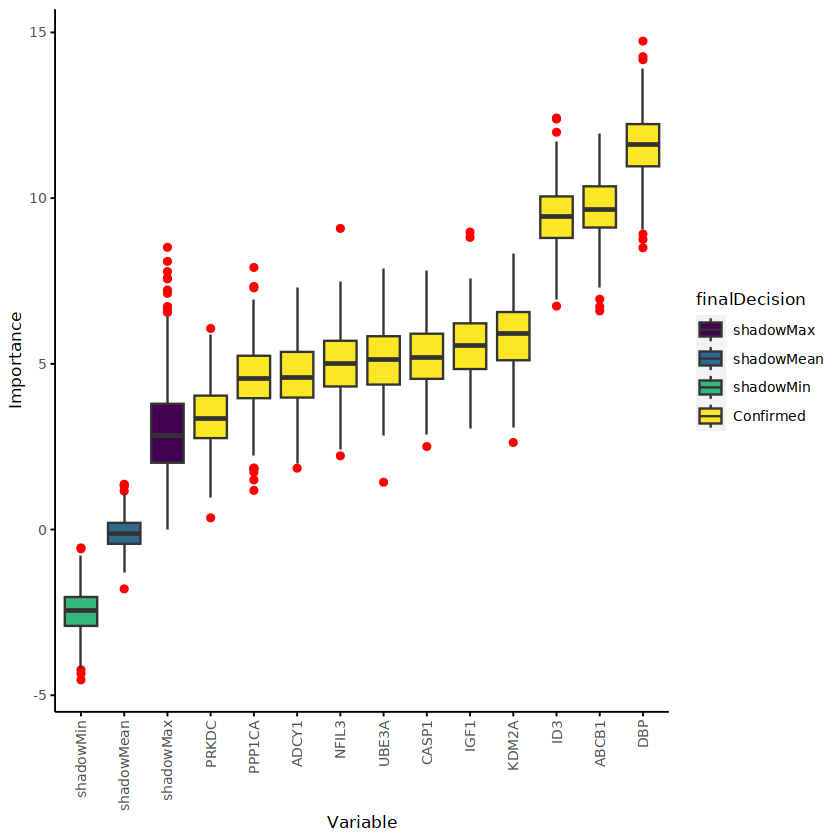

In [35]:
library(YSX)

sp_boxplot(boruta.variable.imp, melted=T, xvariable = "Variable", yvariable = "Importance",
           legend_variable = "finalDecision", legend_variable_order = c("shadowMax", "shadowMean", "shadowMin", "Confirmed"),
           xtics_angle = 90)

In [612]:
expr3 = expr[,-1]

In [613]:
set.seed(147)  
index <-  which( (1:nrow(expr3))%%3 == 0 )
train <- expr3[-index,]
test <- expr3[index,]

In [614]:
table(test$Group)


    MDD control 
     36      17 

In [615]:
library("xgboost")
library("Matrix")
train_matrix <- sparse.model.matrix(Group ~ .-1, data = train)
test_matrix <- sparse.model.matrix(Group ~ .-1, data = test)

In [616]:
train_label <- as.numeric(train$Group == 'MDD')
test_label <-  as.numeric(test$Group == 'MDD')

In [617]:
test_label

[1] 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1
[39] 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0

In [618]:
train_fin <- list(data=train_matrix,label=train_label) 
test_fin <- list(data=test_matrix,label=test_label) 
dtrain <- xgb.DMatrix(data = train_fin$data, label = train_fin$label) 
dtest <- xgb.DMatrix(data = test_fin$data, label = test_fin$label)

In [619]:
xgb <- xgboost(data = dtrain,max_depth=6, eta=0.5,  
  objective='binary:logistic', nround=25)

[1]	train-logloss:0.439522 
[2]	train-logloss:0.319404 
[3]	train-logloss:0.240208 
[4]	train-logloss:0.193626 
[5]	train-logloss:0.165970 
[6]	train-logloss:0.136298 
[7]	train-logloss:0.114556 
[8]	train-logloss:0.102367 
[9]	train-logloss:0.089028 
[10]	train-logloss:0.079844 
[11]	train-logloss:0.071679 
[12]	train-logloss:0.065870 
[13]	train-logloss:0.062183 
[14]	train-logloss:0.058489 
[15]	train-logloss:0.055100 
[16]	train-logloss:0.052339 
[17]	train-logloss:0.050408 
[18]	train-logloss:0.047974 
[19]	train-logloss:0.046252 
[20]	train-logloss:0.044716 
[21]	train-logloss:0.043538 
[22]	train-logloss:0.042259 
[23]	train-logloss:0.040863 
[24]	train-logloss:0.039614 
[25]	train-logloss:0.038727 


In [620]:
xgb

##### xgb.Booster
raw: 27.5 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max_depth = 6, eta = 0.5, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "6", eta = "0.5", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 24 
niter: 25
nfeatures : 24 
evaluation_log:
    iter train_logloss
       1    0.43952173
       2    0.31940383
---                   
      24    0.03961358
      25    0.03872701

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
DBP,0.32700158,0.22600304,0.15151515
ADCY1,0.16148039,0.12375092,0.10101010
ABCB1,0.08651364,0.06444236,0.05050505
GABRB3,0.04664664,0.03346408,0.05050505
NFIL3,0.04191375,0.05562052,0.06060606
ID3,0.03918601,0.07242418,0.07070707


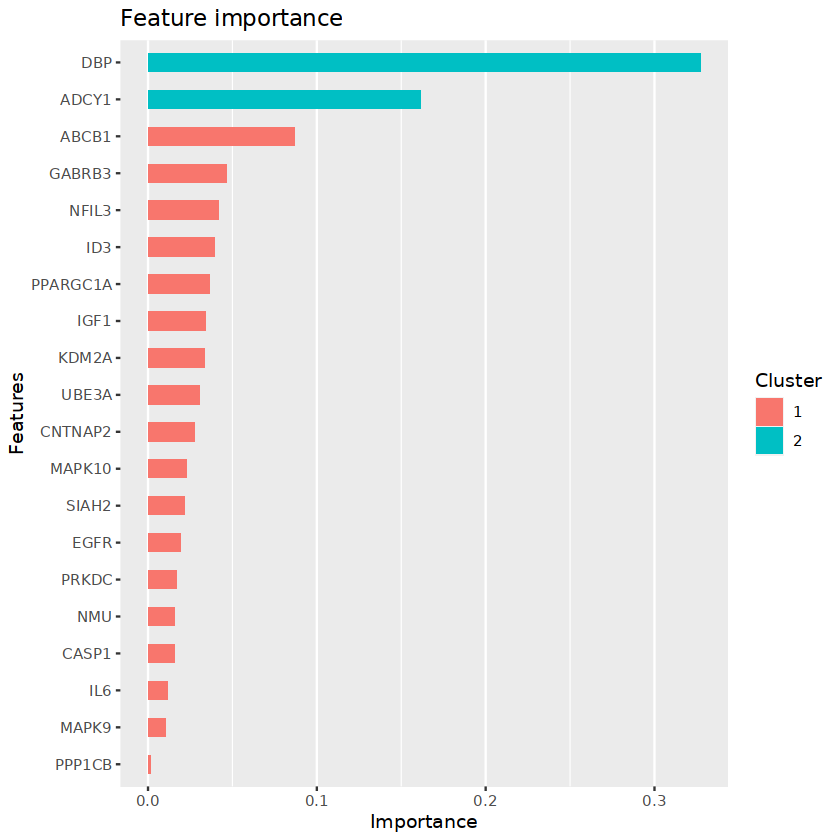

In [621]:
importance <- xgb.importance(train_matrix@Dimnames[[2]], model = xgb)  
head(importance)
xgb.ggplot.importance(importance)

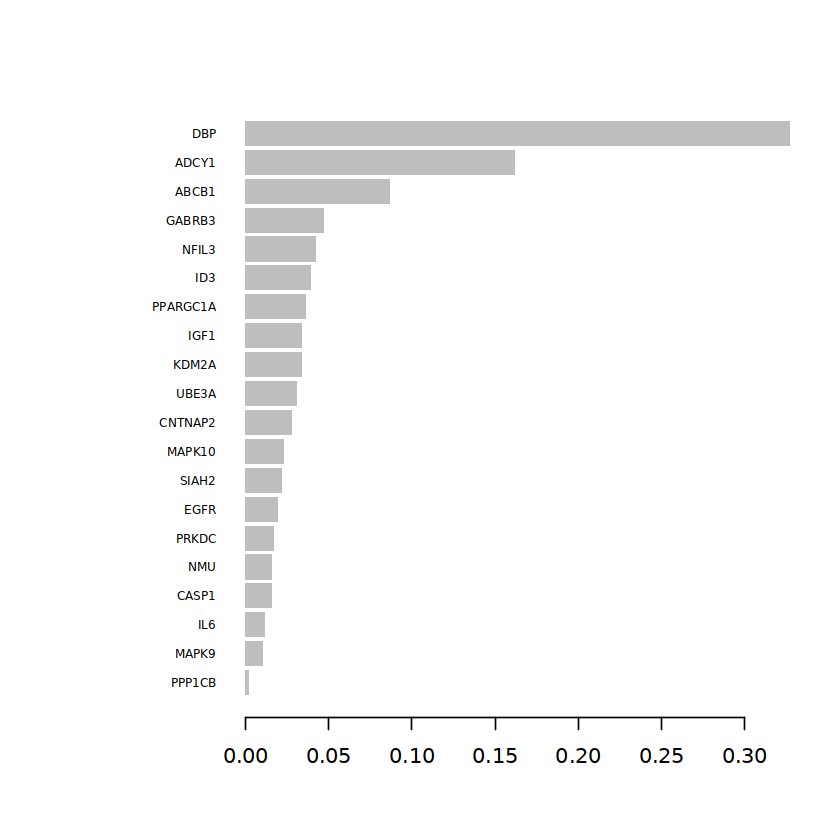

In [622]:
xgb.plot.importance(importance)

### 韦恩图

In [623]:
RF.gene = colnames(sigExp)
SVF.RFE.gene = featureGenes
boruta.variable.imp2 = boruta.variable.imp %>% dplyr::filter(finalDecision == 'Confirmed') %>% select(Variable) %>% unique()

XGBoost.gene = importance$Feature

In [624]:
Boruta.gene = as.vector(boruta.variable.imp2$Variable)

In [625]:
list1 = list(RF.gene,Boruta.gene,XGBoost.gene)

In [626]:
data =  as.data.frame (do.call (cbind, list1))

In [627]:

library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

    if (ncol(data) == 2){
        sample_list <- list(c1 = data[,1], c2 = data[,2])
    }else if(ncol(data) == 3){
        sample_list <- list(RF.gene = data[,1], Boruta.gene = data[,2], XGBoost.gene = data[,3])
    }else if(ncol(data) == 4){
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], XGBoost.gene = data[,4])
    }else{
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], c4 = data[,4], c5 = data[,5])
    }
    
    q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', ncol(data)), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

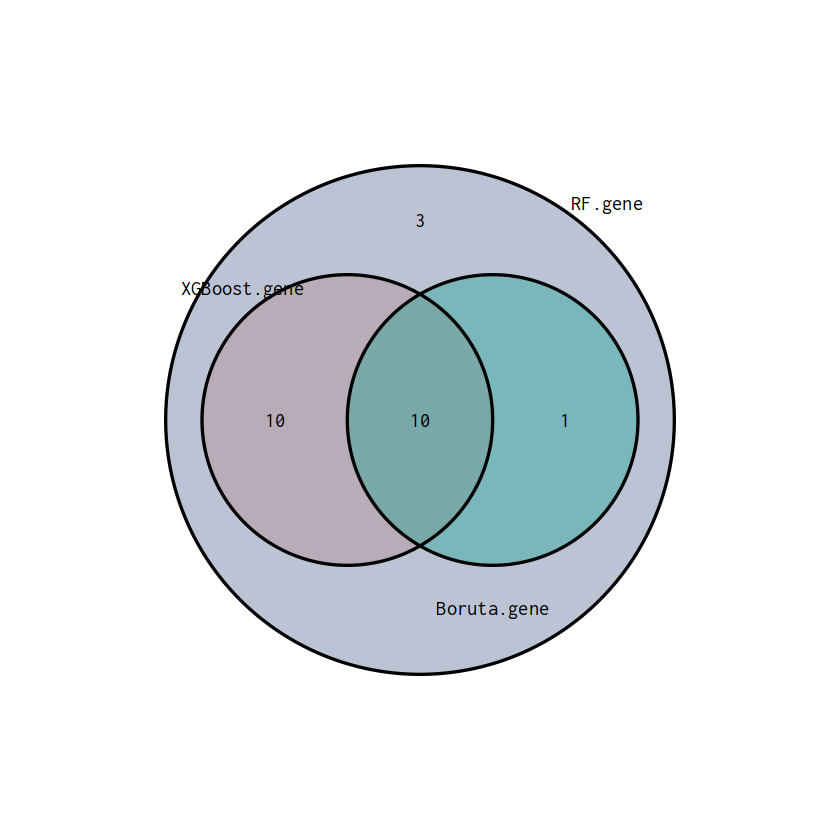

In [668]:
grid.draw(q)

In [628]:
model.gene = intersect(intersect(RF.gene,XGBoost.gene),Boruta.gene)

In [629]:
set.seed(1234)

In [630]:
expr3[expr3$Group =='MDD',]$Group<-1
expr3[expr3$Group =='control',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [631]:
expr4 = expr3 %>% select(c(Group,model.gene))

In [632]:
dim(expr4)

[1] 161  11

In [633]:
head(expr4,4)

,Group,ABCB1,DBP,ADCY1,ID3,CASP1,UBE3A,IGF1,KDM2A,PRKDC,NFIL3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1124358,0,2.006582,2.088067,2.209855,2.105605,1.826383,2.016419,1.915631,2.147506,1.980718,2.361215
GSM1124359,1,2.014495,2.141035,2.248393,2.113936,1.775478,2.046408,1.966743,2.094748,2.013405,1.941229
GSM1124360,1,1.974940,2.113552,2.218243,2.108627,1.768256,2.051127,1.938390,2.062018,2.032160,1.982229
GSM1124361,1,1.939753,2.082876,2.230106,2.064477,1.782100,2.038447,1.955200,2.128754,2.007222,1.933711


In [634]:
library(caret)
library(ggplot2)

In [635]:
for (i in model.gene){
    res<-pROC::roc(Group~expr4[,i],data=expr4,aur=TRUE,
         ci=TRUE, # 显示95%CI
         #percent=TRUE, # 是否需要以百分比显示
         smooth=FALSE,# 是否平滑曲线
         levels=c(0,1),direction=">" #设置分组方向
         )

p = pROC::ggroc(res, color ="red",legacy.axes = TRUE)+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype=4)+
  theme_bw() + # 设置背景
  ggtitle(paste0(i," ROC Curve"))+
  theme(plot.title = element_text(hjust = 0.5,size = 16),
        axis.text=element_text(size=12,colour = "black"),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))
p+annotate("text",x=0.75,y=0.25,label=paste("AUC = ", round(res$auc,3)))+
  annotate("text",x=0.75,y=0.20,label=paste("95%CI: ", round(res$ci[1],3),'-',round(res$ci[3],3)))
    ggsave(file = paste0(i,'.ROC.pdf'))
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### 批量单因素逻辑回归

In [671]:
#结果合并需要的包
library(plyr)
#可进行logistic回归的包
library(rms)#可实现逻辑回归模型（lrm）
library(epiDisplay)#快速输出OR、95%CI、P
#library(gtsummary)#精美三线表（但，95%CI有误）

In [675]:
varsU<-names(expr4[,2:11])

In [676]:
Result<-c()
for (i in 1:length(varsU)){
  fit<-glm(substitute(Group~x,list(x=as.name(varsU[i]))),data=expr4,family=binomial())
  fitSum<-summary(fit)
  result1<-c()
  result1<-rbind(result1,fitSum$coef)
  OR<-exp(fitSum$coef[,'Estimate'])
  result1<-data.frame(cbind(result1,cbind(OR,exp(confint(fit)))))
  result1$Characteristics<-varsU[i]   #添加变量名
  Result<-rbind(Result,result1[-1,])#[-1,],删除常数项
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [677]:
Result

,Estimate,Std..Error,z.value,Pr...z..,OR,X2.5..,X97.5..,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ABCB1,-15.814839,3.454465,-4.578086,4.692490e-06,1.354262e-07,9.713144e-11,8.144134e-05,ABCB1
DBP,38.953623,8.332641,4.674823,2.942072e-06,8.266915e+16,1.885416e+10,3.475916e+24,DBP
ADCY1,35.853925,8.795126,4.076568,4.570535e-05,3.725305e+15,3.130042e+08,3.772936e+23,ADCY1
ID3,-20.658423,5.193664,-3.977620,6.960846e-05,1.066991e-09,2.096714e-14,1.662153e-05,ID3
CASP1,-27.621609,7.284300,-3.791937,1.494767e-04,1.009457e-12,3.057889e-19,9.500422e-07,CASP1
UBE3A,18.202282,4.949096,3.677901,2.351616e-04,8.038047e+07,8.138889e+03,2.462740e+12,UBE3A
IGF1,35.226351,9.492264,3.711059,2.063940e-04,1.988886e+15,4.272847e+07,7.528241e+23,IGF1
KDM2A,-26.647075,7.807494,-3.413013,6.424899e-04,2.674992e-12,2.028575e-19,5.087432e-06,KDM2A
PRKDC,12.262778,3.579276,3.426049,6.124290e-04,2.116687e+05,2.747481e+02,3.751480e+08,PRKDC


In [678]:
Uni_log<-data.frame(Result[,c(1,4:8)]) #提取"P","OR","CIlower","CIupper"和变量名

colnames(Uni_log)[2:5]<-c("P","OR","CIlower","CIupper")#变量重命名

ExtractVar<-unique(Uni_log$Characteristics[Uni_log$"P"<0.05]) 

In [680]:
Uni_log

,Estimate,P,OR,CIlower,CIupper,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ABCB1,-15.814839,4.692490e-06,1.354262e-07,9.713144e-11,8.144134e-05,ABCB1
DBP,38.953623,2.942072e-06,8.266915e+16,1.885416e+10,3.475916e+24,DBP
ADCY1,35.853925,4.570535e-05,3.725305e+15,3.130042e+08,3.772936e+23,ADCY1
ID3,-20.658423,6.960846e-05,1.066991e-09,2.096714e-14,1.662153e-05,ID3
CASP1,-27.621609,1.494767e-04,1.009457e-12,3.057889e-19,9.500422e-07,CASP1
UBE3A,18.202282,2.351616e-04,8.038047e+07,8.138889e+03,2.462740e+12,UBE3A
IGF1,35.226351,2.063940e-04,1.988886e+15,4.272847e+07,7.528241e+23,IGF1
KDM2A,-26.647075,6.424899e-04,2.674992e-12,2.028575e-19,5.087432e-06,KDM2A
PRKDC,12.262778,6.124290e-04,2.116687e+05,2.747481e+02,3.751480e+08,PRKDC


In [636]:
x = as.matrix(expr4[,c(2:11)])
y=expr4$Group

In [637]:
library(glmnet)

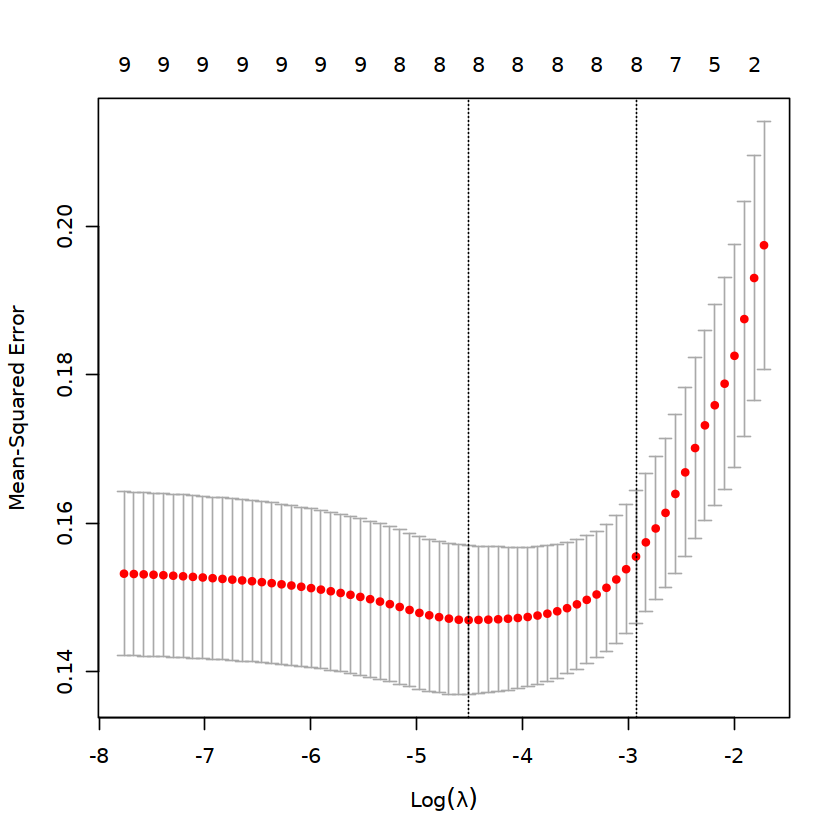

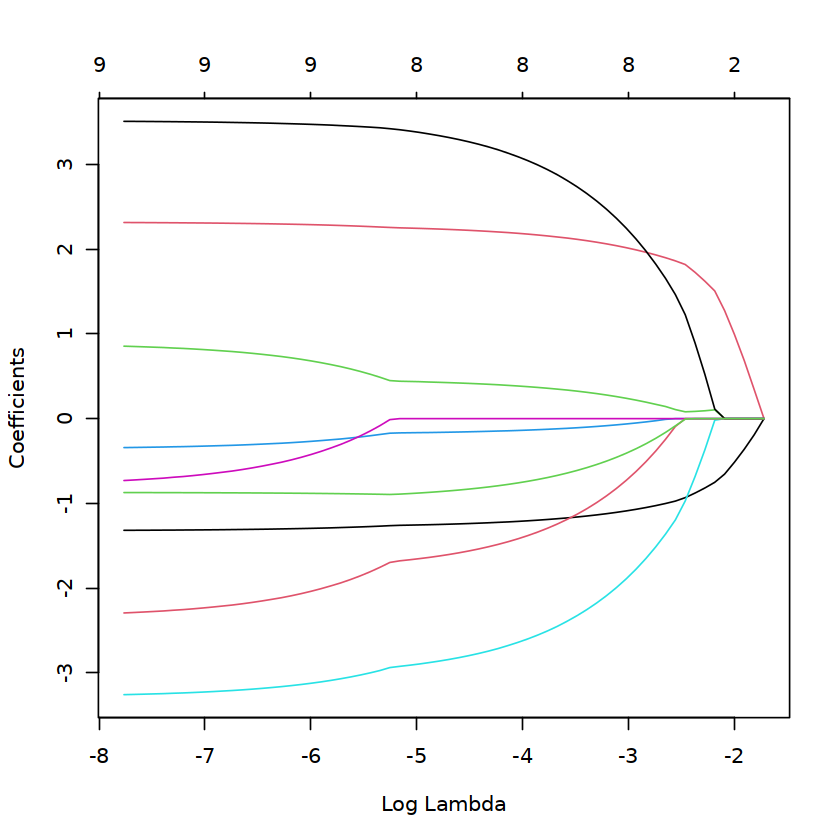

In [638]:
set.seed(1006) # 选取不同的数，画出来的效果不同
cv_fit <- cv.glmnet(x=x, y=y)
plot(cv_fit)

#系数图
fit <- glmnet(x=x, y=y)
plot(fit,xvar = "lambda")

In [639]:
model_lasso_min <- glmnet(x=x, y=y,lambda=cv_fit$lambda.min)
model_lasso_1se <- glmnet(x=x, y=y,lambda=cv_fit$lambda.1se)

In [640]:
head(model_lasso_min$beta,20)
choose_gene_min=rownames(model_lasso_min$beta)[as.numeric(model_lasso_min$beta)!=0]
choose_gene_1se=rownames(model_lasso_1se$beta)[as.numeric(model_lasso_1se$beta)!=0]


10 x 1 sparse Matrix of class "dgCMatrix"
              s0
ABCB1 -1.2381711
DBP    2.2233905
ADCY1  0.4172454
ID3   -0.1562710
CASP1 -2.7949367
UBE3A  .        
IGF1   3.2652361
KDM2A -1.5619783
PRKDC  .        
NFIL3 -0.8314970

In [641]:
proj = 'crg'

In [642]:
length(choose_gene_min)
length(choose_gene_1se)
save(choose_gene_min,file = paste0(proj,"_lasso_choose_gene_min.Rdata"))
save(choose_gene_1se,file = paste0(proj,"_lasso_choose_gene_1se.Rdata"))

[1] 8

[1] 8

In [500]:
lasso.prob <- predict(cv_fit, newx=x , s=c(cv_fit$lambda.min,cv_fit$lambda.1se) )
re=cbind(y ,lasso.prob)

In [502]:
re=as.data.frame(re)
colnames(re)=c('event','prob_min','prob_1se')
re$event=as.factor(re$event)
head(re)

,event,prob_min,prob_1se
,<fct>,<dbl>,<dbl>
GSM1124358,0,0.04019738,0.3601409
GSM1124359,1,0.90386809,0.8461003
GSM1124360,1,0.82464136,0.7859708
GSM1124361,1,0.76413221,0.7540122
GSM1124362,1,1.05048490,0.9615162
GSM1124363,1,0.22225827,0.3919218


In [507]:
library(survival)
library(survminer)

Warning message:
"package 'survival' was built under R version 4.2.3"

Attaching package: 'survival'


The following object is masked from 'package:future':

    cluster


The following object is masked from 'package:caret':

    cluster


Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 4.2.3"

Attaching package: 'ggpubr'


The following object is masked from 'package:VennDiagram':

    rotate



Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma




Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8703

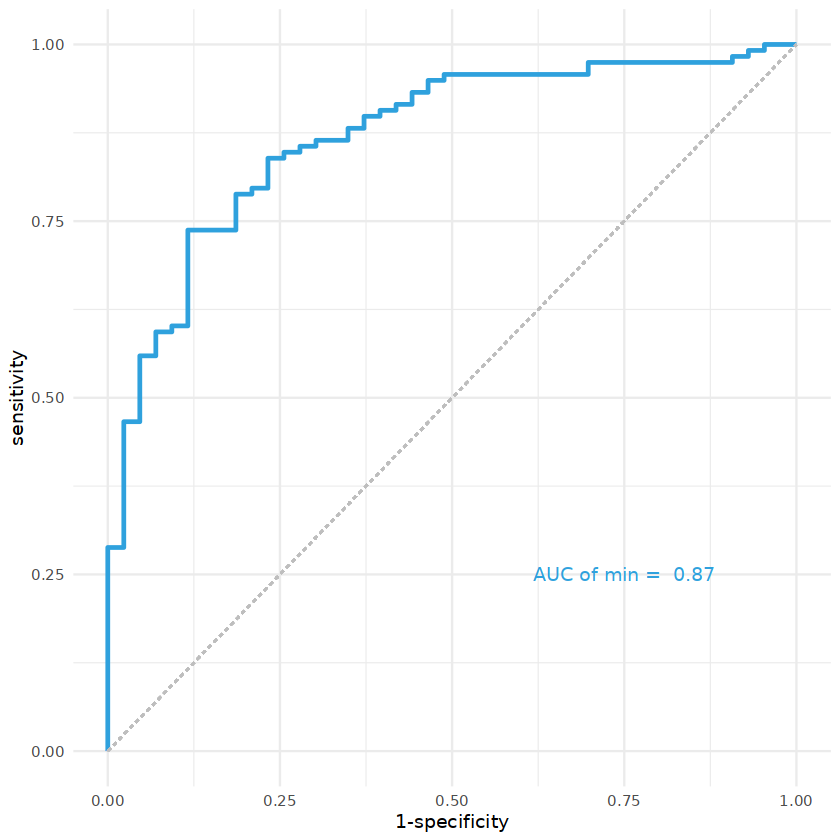

In [514]:
library(psych)
library(ggplot2)
m <- pROC::roc(re$event, re$prob_min)
g <- pROC::ggroc(m,legacy.axes = T,size = 1,color = "#2fa1dd")
pROC::auc(m)  # Area under the curve: 0.9953

g + theme_minimal() +
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               colour = "grey", linetype = "dashed")+
  annotate("text",x = .75, y = .25,
           label = paste("AUC of min = ",format(round(as.numeric(pROC::auc(m)),2),nsmall = 2)),color = "#2fa1dd")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8664

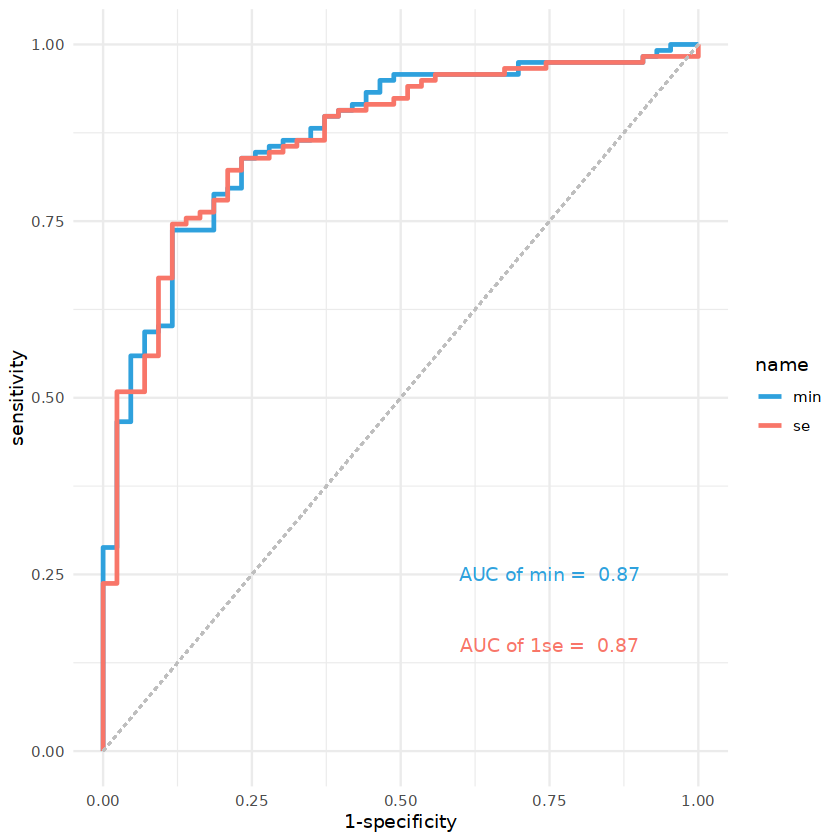

In [515]:
m2 <- pROC::roc(re$event, re$prob_1se)
pROC::auc(m2) # Area under the curve: 0.9136
g <- pROC::ggroc(list(min = m,se = m2),legacy.axes = T,size = 1)

g + theme_minimal() +
  scale_color_manual(values = c("#2fa1dd", "#f87669"))+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               colour = "grey", linetype = "dashed")+
  annotate("text",x = .75, y = .25,
           label = paste("AUC of min = ",format(round(as.numeric(pROC::auc(m)),2),nsmall = 2)),color = "#2fa1dd")+
  annotate("text",x = .75, y = .15,
           label = paste("AUC of 1se = ",format(round(as.numeric(pROC::auc(m2)),2),nsmall = 2)),color = "#f87669")

In [522]:
proj = "crg"
if(!require(My.stepwise))install.packages("My.stepwise")
#load(paste0(proj,"_sur_model.Rdata"))
load(paste0(proj,"_lasso_choose_gene_1se.Rdata"))
g = choose_gene_1se

In [650]:
XX<-cor(expr4[-c(1)])
kappa(XX,exact = TRUE)  # 也可以计算条件数kappa(X)，k<100,说明共线性程度小；
#如果100<k<1000，则存在较多的多重共线性;若k>1000，存在严重的多重共线性。

[1] 44.02096

In [658]:
data = expr4

In [662]:
train_sub = sample(nrow(data),9/10*nrow(data))
train_data = data[train_sub,]
test_data =data[-train_sub,]

In [663]:
fit.reduce<-glm(Group~.,data=train_data,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ ., family = binomial(), data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5630  -0.3888   0.3631   0.5527   2.5858  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -35.811     78.172  -0.458   0.6469  
ABCB1         -8.791      5.080  -1.730   0.0835 .
DBP           27.439     10.981   2.499   0.0125 *
ADCY1         -3.498     15.201  -0.230   0.8180  
ID3           -2.173      8.376  -0.259   0.7953  
CASP1        -15.639     13.047  -1.199   0.2306  
UBE3A         -3.204     14.415  -0.222   0.8241  
IGF1          23.462     13.333   1.760   0.0785 .
KDM2A          1.161     14.222   0.082   0.9349  
PRKDC          5.231      9.944   0.526   0.5989  
NFIL3         -7.716      4.219  -1.829   0.0674 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 170.16  on 143  degrees of freedom
Residua

In [661]:
formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(fit.reduce)

Waiting for profiling to be done...



,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),40.592,0.206,425675993024693120(0~2.31570362164834e+96),0.650
ABCB1,-6.570,1.178,0.001(0~183.03),0.278
DBP,8.200,0.537,3640.997(0~37774185892415.9),0.464
ADCY1,2.566,0.022,13.014(0~13051711422399988),0.883
ID3,-3.432,0.136,0.032(0~2367475.253),0.713
CASP1,-1.260,0.007,0.284(0~3503878267340.54),0.933
UBE3A,-3.573,0.043,0.028(0~15536732736238.6),0.836
IGF1,9.060,0.316,8600.94(0~1520640036253629440),0.574
KDM2A,-26.455,2.545,0(0~1330.166),0.111


In [647]:
fit<-glm(Group~.,data=expr4,family=binomial())
summary(fit)

fit.reduce<-glm(Group~.,data=expr4,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ ., family = binomial(), data = expr4)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3954  -0.3988   0.3763   0.5601   2.4114  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   24.426     66.638   0.367   0.7140  
ABCB1         -8.179      4.800  -1.704   0.0884 .
DBP           17.554      9.394   1.869   0.0617 .
ADCY1          3.737     13.557   0.276   0.7828  
ID3            1.401      7.722   0.181   0.8561  
CASP1        -21.672     12.540  -1.728   0.0839 .
UBE3A         -2.755     12.946  -0.213   0.8315  
IGF1          23.906     12.963   1.844   0.0651 .
KDM2A        -18.624     12.339  -1.509   0.1312  
PRKDC         -2.909      8.415  -0.346   0.7296  
NFIL3         -6.162      3.787  -1.627   0.1037  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual dev


Call:
glm(formula = Group ~ ., family = binomial(), data = expr4)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3954  -0.3988   0.3763   0.5601   2.4114  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   24.426     66.638   0.367   0.7140  
ABCB1         -8.179      4.800  -1.704   0.0884 .
DBP           17.554      9.394   1.869   0.0617 .
ADCY1          3.737     13.557   0.276   0.7828  
ID3            1.401      7.722   0.181   0.8561  
CASP1        -21.672     12.540  -1.728   0.0839 .
UBE3A         -2.755     12.946  -0.213   0.8315  
IGF1          23.906     12.963   1.844   0.0651 .
KDM2A        -18.624     12.339  -1.509   0.1312  
PRKDC         -2.909      8.415  -0.346   0.7296  
NFIL3         -6.162      3.787  -1.627   0.1037  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 186.87  on 160  degrees of freedom
Residual dev

In [648]:
formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(fit.reduce)

Waiting for profiling to be done...



,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),24.426,0.134,40541022079.739(0~1.05987583306517e+68),0.7140
ABCB1,-8.179,2.904,0(0~2.977),0.0884
DBP,17.554,3.492,42037688.161(0.798~10192777624334226),0.0617
ADCY1,3.737,0.076,41.971(0~17484508601499.7),0.7828
ID3,1.401,0.033,4.057(0~14651929.329),0.8561
CASP1,-21.672,2.987,0(0~12.133),0.0839
UBE3A,-2.755,0.045,0.064(0~7804031292.794),0.8315
IGF1,23.906,3.401,24110680355.929(0.879~1.60856839379589e+22),0.0651
KDM2A,-18.624,2.278,0(0~290.576),0.1312


In [664]:
fitstep <- glm(formula = Group ~ ., family = "binomial", data = expr4)
fitSum<-summary(fitstep)
ResultMul<-c()#准备空向量，用来储存结果
ResultMul<-rbind(ResultMul,fitSum$coef)
OR<-exp(fitSum$coef[,'Estimate'])
ResultMul<-cbind(ResultMul,cbind(OR,exp(confint(fitstep))))


Waiting for profiling to be done...



In [665]:
ResultMul

,Estimate,Std. Error,z value,Pr(>|z|),OR,2.5 %,97.5 %
(Intercept),24.425580,66.638489,0.3665386,0.71396320,4.054102e+10,2.677396e-47,1.059876e+68
ABCB1,-8.178863,4.799593,-1.7040745,0.08836718,2.805206e-04,1.696071e-08,2.976690e+00
DBP,17.554077,9.394278,1.8685925,0.06167953,4.203769e+07,7.983794e-01,1.019278e+16
ADCY1,3.736979,13.556946,0.2756505,0.78281653,4.197099e+01,9.225769e-11,1.748451e+13
ID3,1.400552,7.721983,0.1813721,0.85607554,4.057440e+00,7.840050e-07,1.465193e+07
CASP1,-21.672105,12.540058,-1.7282300,0.08394700,3.871903e-10,3.190723e-21,1.213264e+01
UBE3A,-2.755120,12.946368,-0.2128102,0.83147498,6.360141e-02,4.901254e-13,7.804031e+09
IGF1,23.905921,12.962541,1.8442310,0.06514948,2.411068e+10,8.794768e-01,1.608568e+22
KDM2A,-18.624176,12.338730,-1.5094079,0.13119458,8.158740e-09,1.528713e-19,2.905763e+02
PRKDC,-2.909245,8.415013,-0.3457208,0.72955253,5.451686e-02,3.189715e-09,9.497681e+05


In [286]:
# pre_xgb = round(predict(xgb,newdata = dtest))
# table(test_label,pre_xgb,dnn=c("true","pre"))

    pre
true  0  1
   0  7 10
   1  2 34

### 多元二分类逻辑回归分析

In [ ]:
#把affairs从连续变量转为分类变量0和1
expr3[expr3$Group =='MDD',]$Group<-1

expr3[expr3$Group =='control',]$Group<-0

expr3$Group = as.numeric(expr3$Group)

head(expr3,4)